# Normalised mutational profiles in EV Fig 2A

In [1]:
import json
import re

from intervaltree import IntervalTree
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import rcParams
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [3]:
data_dir = './data'

In [4]:
ctypes_to_plot = [
    'ALL',
    'BILIARY_TRACT',
    'BLADDER_URI',
    'BOWEL',
    'BRCA',
    'BRAIN',
    'CERVIX',
    'COADREAD',
    'ES',
    'ESOPHA_STOMACH',
    'GBM',
    'HEAD_NECK',
    'KIDNEY',
    'LIVER',
    'LUNG',
    'NSCLC',
    'OV',
    'PANCREAS',
    'PROSTATE',
    'SCLC',
    'SKCM',
    'SKIN',
    'ST',
    'UCEC'
]

In [5]:
signatures = [
     'SBS1',
     'SBS2',
     'SBS3',
     'SBS4',
     'SBS5',
     'SBS7a',
     'SBS7b',
     'SBS7c',
     'SBS7d',
     'SBS8',
     'SBS10c',
     'SBS12',
     'SBS13',
     'SBS16',
     'SBS17a',
     'SBS17b',
     'SBS18',
     'SBS30',
     'SBS31',
     'SBS35',
     'SBS36',
     'SBS38',
     'SBS39',
     'SBS40',
     'SBS41',
     'SBS85',
     'SBS92',
     'SBS93'
]

In [6]:
sigs_color = {
     'SBS1': '#1e79baff',
     'SBS2': '#ff9896ff',
     'SBS5': '#71b6e8ff',
     'SBS8': '#3dbe3dff',
     'SBS10c': '#8d8d8dff',
     'SBS13': '#d62728ff',
     'SBS17a': '#ffbb78ff',
     'SBS17b': '#ff8921ff',
     'SBS18': '#9467bdff',
     'SBS35': '#a4e6a4ff',
     'SBS40': '#c2e0f5ff',
     'SBS85': '#db5a68ff',
     'SBS88': '#b96a33ff',
     'SBS93': '#c5b0d5ff',
     'SBS94': '#ffe680ff',
     'SBS4': '#00a572ff', 
     'SBS92': '#94e5cdff',
     'SBS3': '#f6c200ff', 
     'SBS7a': '#8c564bff', 
     'SBS7b': '#c49c94ff', 
     'SBS16': '#e2ef75ff', 
     'SBS41': '#cd99ceff'
}

### Load data

- Table with fold change enrichment of a signature inside vs outside hotspots across cancer types. 
- JSON file containing the activity of a signature inside and outside hotspots per sample in a cancer type. Only samples where the signature under analysis is active are listed. 

In [7]:
fold_change_f = f'{data_dir}/signatures_fold_change_inside_outside.txt'
fold_change_df = pd.read_csv(fold_change_f, sep='\t', header=0)
fold_change_df.head(3)

,CANCER_TYPE,SIGNATURE,SAMPLES_ACTIVE,SAMPLES_ACTIVE_F,MUTS,IN,OUT,FC_MEDIAN,PVALUE,QVALUE,SIG,FC_LOG2
0,ALL,SBS1,233,0.970833,78.598630,0.136313,0.215240,0.490111,0.016636,0.019013,no,-1.028820
1,ALL,SBS13,26,0.108333,195.230656,0.043008,0.244970,0.201052,0.000008,0.000022,yes,-2.314360
2,ALL,SBS18,49,0.204167,100.407321,0.138802,0.248749,0.565514,0.000975,0.001301,yes,-0.822365


In [8]:
activity_f = f'{data_dir}/sample_signatures_fraction_activity_inside_outside.json'
with open(activity_f, 'r') as fd: 
    activity_dict = json.load(fd)
activity_dict['COADREAD::SBS1'].keys()

dict_keys(['M_IN_FRACTION', 'M_OUT_FRACTION'])

## Panel EV2A 

In [9]:
# Color palette for heatmap
tree_colors_fraction = IntervalTree()
cutoffs = [0, 0.5, 0.75, 1, 1.25, 2, 4]
palette = sns.color_palette('coolwarm', len(cutoffs)).as_hex()
legend_elements_color = []
msize = 10
for c_minus_1, c in enumerate(cutoffs[1:]): 
    start = cutoffs[c_minus_1]
    end = c
    color = palette[c_minus_1]
    tree_colors_fraction.addi(start, end, color)
    legend_elements_color.append(Line2D([0], [0], marker='s', color='w', label=f'{start}-{end}', markerfacecolor=color, markersize=msize))
legend_elements_color = legend_elements_color[::-1]
legend_elements_color.append(Line2D([0], [0], marker='s', color='w', label='', markerfacecolor='w', markersize=msize))

In [10]:
# Prepare data to plot as a heatmap
lines = []
for ctype in sorted(ctypes_to_plot): 
    data = fold_change_df.loc[fold_change_df['CANCER_TYPE'] == ctype]
    for signature in signatures[::-1]: 
        if signature in data['SIGNATURE'].unique(): 
            fold_change = data.loc[data['SIGNATURE'] == signature]['FC_MEDIAN'].iloc[0]
            qvalue = data.loc[data['SIGNATURE'] == signature]['QVALUE'].iloc[0]
            edgecolor = 'black' if qvalue < 0.01 else 'white'
            for i in tree_colors_fraction[fold_change]: 
                color = i.data
            fraction_samples_active = data.loc[data['SIGNATURE'] == signature]['SAMPLES_ACTIVE_F'].iloc[0]
            size = 1
        else: 
            fold_change = fraction_samples_active = qvalue = -1
            color = edgecolor = 'white'
            size = 0
        lines.append(pd.DataFrame([[ctype, signature, color, fold_change, size, edgecolor, qvalue]]))
df = pd.concat(lines)
df.columns = ['ctype', 'signature', 'color', 'fold_change', 'size', 'edgecolor', 'qvalue']
df.head(3)

,ctype,signature,color,fold_change,size,edgecolor,qvalue
0,ALL,SBS93,white,-1.0,0,white,-1.0
0,ALL,SBS92,white,-1.0,0,white,-1.0
0,ALL,SBS85,white,-1.0,0,white,-1.0


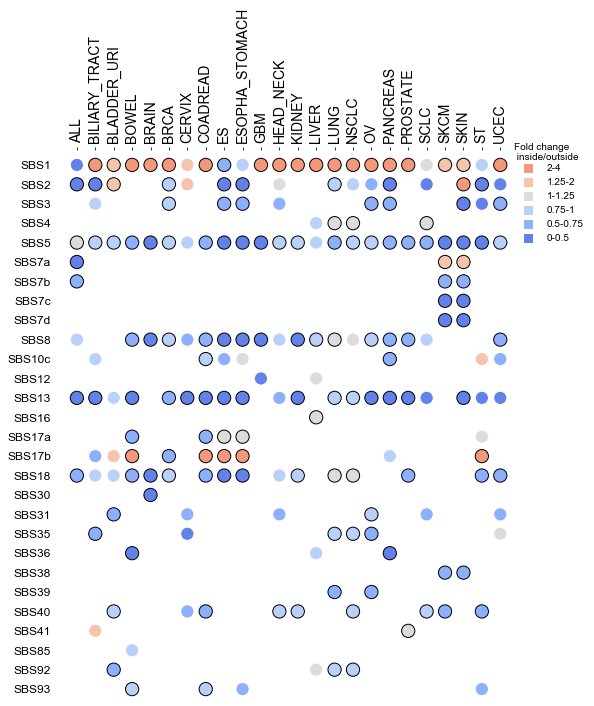

In [11]:
fig = plt.figure(figsize=(8, 10))
ax = plt.subplot2grid((1, 1), (0, 0), frameon=False)

x = df['ctype']
y = df['signature']
sizes = df['size']
colors = df['color']
edgecolors = df['edgecolor']

# Mapping from column names to integer coordinates
x_labels = [v for v in x.unique()]
y_labels = [v for v in y.unique()]
x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 

size_scale = 175
im = ax.scatter(
    x=x.map(x_to_num),
    y=y.map(y_to_num),
    s=sizes * size_scale, 
    marker='o', 
    c=colors, 
    alpha=1,
    edgecolors=edgecolors,
    linewidths=1
)

# Show column labels on the axes
ax.spines['left'].set_position(('outward', 5))
ax.xaxis.tick_top()
ax.spines['top'].set_position(('outward', 5))

ax.set_xticks([x_to_num[v] for v in x_labels])
ax.set_xticklabels(x_labels, rotation=90, horizontalalignment='center', fontsize=14)
ax.set_yticks([y_to_num[v] for v in y_labels])
ax.set_yticklabels(y_labels, fontsize=12)

ax.set_xlim([-0.75, max([v for v in x_to_num.values()]) + 0.5]) 
ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
plt.tick_params(axis = "x", which = "both", bottom=False)
plt.tick_params(axis = "y", which = "both", left=False)

ax.legend(handles=legend_elements_color, bbox_to_anchor=(1, 1), fontsize=10).get_frame().set_edgecolor('w')
ax.text(1.01, 1.005,'Fold change\n inside/outside', ha='left', va='center', transform=ax.transAxes)

for extension in ['png']: 
    output = f'./fig_EV1A.{extension}'
    plt.savefig(output, bbox_inches='tight', dpi=350)

## Panel EV2B

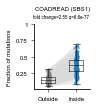

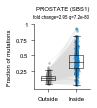

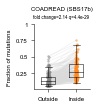

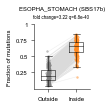

In [12]:
for ctype, signature in [
    ('COADREAD', 'SBS1'), ('PROSTATE', 'SBS1'), ('COADREAD', 'SBS17b'), ('ESOPHA_STOMACH', 'SBS17b')
]:
    # Get data to plot
    subset_df = fold_change_df.loc[(fold_change_df['CANCER_TYPE'] == ctype) & (fold_change_df['SIGNATURE'] == signature)]
    qvalue = subset_df['QVALUE'].iloc[0]
    foldchange = subset_df['FC_MEDIAN'].iloc[0]
    a_in = activity_dict[f'{ctype}::{signature}'][f'M_IN_FRACTION']
    a_out = activity_dict[f'{ctype}::{signature}'][f'M_OUT_FRACTION']

    # Plot
    fig = plt.figure(figsize=(1, 1.2))
    ax = plt.subplot2grid((1, 1), (0, 0))
    plt.rc('axes', edgecolor='black', linewidth=0.5)

    plt.title(f'{ctype} ({signature})', fontsize=6, y=1.12)
    plt.suptitle(f'fold change={foldchange:0.3} q={qvalue:0.1e}', fontsize=4.5, y=1)

    # Boxplots
    boxstyle = dict(linewidth=0.5, color='black')
    ax.boxplot(
        a_out, positions=[1], widths=0.5, medianprops=boxstyle, boxprops=boxstyle, whiskerprops=boxstyle, capprops=boxstyle, showfliers=False)   
    ax.boxplot(
        a_in, positions=[2], widths=0.5, medianprops=boxstyle, boxprops=boxstyle, whiskerprops=boxstyle, capprops=boxstyle, showfliers=False)

    # Lines
    for start, end in list(zip(a_out, a_in)): 
        ax.plot([1, 2], [start, end], color='#dadadaff', alpha=0.5, zorder=0, linewidth=0.5)

    # Scatter
    ax.scatter(np.random.normal(1, scale=0.025, size=len(a_out)), a_out, color='grey', s=6, linewidth=0, alpha=0.5)
    ax.scatter(np.random.normal(2, scale=0.025, size=len(a_in)), a_in, color=sigs_color[signature], s=6, linewidth=0, alpha=0.5)

    yticks = [0.25, 0.5, 0.75, 1]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, fontsize=6, horizontalalignment='right')
    ax.set_ylabel('Fraction of mutations', fontsize=6)
    ax.set_xlabel('', fontsize=6)
    ax.set_xticklabels(['Outside', 'Inside'], fontsize=6)

    plt.tick_params(axis = "x", which = "both", bottom=True)
    plt.tick_params(axis = "y", which = "both", left=True)
    plt.xlim([0.5, 2.5])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_linewidth(0.5)
    ax.spines['top'].set_linewidth(0.5)
    ax.tick_params(axis='both', which='major', left=True, width=0.5, length=3)

    for extension in ['png']: 
        output = f'./fig_EV1B_{ctype}_{signature}.{extension}'
        plt.savefig(output, bbox_inches='tight', dpi=350)

## Panel EV2C

In [13]:
fold_change_df['MINUS_LOG10_QVALUE'] = fold_change_df.apply(lambda x: -np.log10(x['QVALUE']), axis=1)

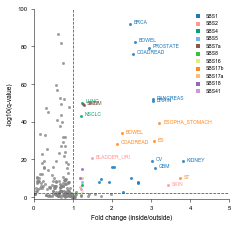

In [14]:
fig = plt.figure(figsize=(3.5, 3.5))
ax = plt.subplot2grid((1, 1), (0, 0))
plt.axvline(x=1, color='r', linestyle='--', linewidth=0.75)
plt.axhline(y=-np.log10(0.01), color='r', linestyle='--', linewidth=0.75)
ax.set_xlabel('Fold change (inside/outside)', fontsize=6.5)
ax.set_ylabel('-log10(q-value)', fontsize=6.5)

legend_elements = []
slope_text = 0

# Plot significant enriched
df = fold_change_df.loc[(fold_change_df['SIG'] == 'yes') & (fold_change_df['FC_MEDIAN'] > 1)].copy()
labels = list(df['SIGNATURE'].unique())
sorted_sigs = list(list(zip(*sorted(list(zip(list(map(lambda x: int(re.findall('[0-9]+', x)[0]), labels)), labels)), key=lambda tup: tup[0])))[-1])

for signature, data in df.groupby('SIGNATURE'): 
    color = sigs_color.get(signature, 'black')
    if color == 'black': 
        print(signature)
    y = data['MINUS_LOG10_QVALUE'].tolist()
    x = data['FC_MEDIAN'].tolist()
    labels = data['CANCER_TYPE'].tolist()
    plt.plot(x, y, '.', markersize=6, linewidth=0, markeredgewidth=0, color=color, alpha=0.85, zorder=1)
    for xi, yi, li in list(zip(x, y, labels)): 
        if yi >= 20 or xi >= 3: 
            ax.annotate(
                s=li, xy=(xi, yi), xytext=(xi+0.1, yi+slope_text), fontsize=5, color=color)
            
# Plot significant non-enriched
df = fold_change_df.loc[(fold_change_df['SIG'] == 'yes') & (fold_change_df['FC_MEDIAN'] <= 1)].copy()
y = df['MINUS_LOG10_QVALUE'].tolist()
x = df['FC_MEDIAN'].tolist()
plt.plot(x, y, '.', markersize=6, linewidth=0, markeredgewidth=0, color='grey', alpha=0.75, zorder=1)

# Plot non-significant
df = fold_change_df.loc[fold_change_df['SIG'] == 'no'].copy()
y = df['MINUS_LOG10_QVALUE'].tolist()
x = df['FC_MEDIAN'].tolist()
plt.plot(x, y, '.', markersize=6, linewidth=0, markeredgewidth=0, color='grey', alpha=0.75, zorder=0)

plt.xlim(right=5, left=0) 
plt.ylim(top=100, bottom=-1) 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
yticks = [0, 20, 40, 60, 80, 100]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=6, horizontalalignment='right')
xticks = [0, 1, 2, 3, 4, 5]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=6)
ax.spines['right'].set_linewidth(0.5)
ax.spines['top'].set_linewidth(0.5)
ax.tick_params(axis='both', which='major', left=True, width=0.5, length=3)

for sig in sorted_sigs: 
    legend_elements.append(Line2D([0], [0], marker='s', color='w', label=sig, markerfacecolor=sigs_color[sig], markersize=5))
ax.legend(handles=legend_elements, bbox_to_anchor=(1, 1), fontsize=5).get_frame().set_edgecolor('w')

for extension in ['png']: 
    output = f'./fig_EV1C.{extension}'
    plt.savefig(output, bbox_inches='tight', dpi=350)